In [ ]:
import numpy as np
from tensorflow import keras
import soundfile
import json

import random
from python_speech_features import mfcc
import librosa
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from keras import backend as K
from keras.models import Model
from keras.layers import (BatchNormalization, Conv1D, Dense, Input, 
    TimeDistributed, Activation, Bidirectional, SimpleRNN, GRU, LSTM)
from keras.utils.vis_utils import plot_model


import _pickle as pickle
from numpy.lib.stride_tricks import as_strided

from keras.layers import (Input, Lambda)
from tensorflow.keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint   
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!ls /content/drive/"My Drive"

 ALFFA_PUBLIC
 Amharic
 AMHARIC
 Classroom
'Colab Notebooks'
'Contact Information (File responses)'
'Contact Information (Responses).gsheet'
'Copy of WEEK 4 CAREER EXERCISE.gdoc'
 CV.docx
'Navigating Remote Workspaces.gslides'
 personaldocs
'powerpoint 1'
'Project data'
'Stella Makena Mutacho -Task.pdf'
'Strategy Management task.docx'
 SWAHILI
'week 1 career task.gdoc'


In [ ]:
import os
os.chdir("/content/drive/My Drive/AMHARIC")
os.listdir()

['README.md', 'data', 'kaldi-script', 'lang', 'lm']

In [ ]:
os.listdir()

['README.md', 'data', 'kaldi-script', 'lang', 'lm']

In [ ]:
train_audio_path = 'data/train/wav/SWH-05-20101106/'
samples, sample_rate = librosa.load(train_audio_path+'SWH-05-20101106_16k-emission_swahili_05h30_-_06h00_tu_20101106_part2.wav')
print(samples)
print(sample_rate)

[ 0.00949342  0.01522155  0.01770687 ... -0.21883075 -0.20150991
  0.        ]
22050


Sampling at *44100HZ* instead of the default sampling rate of 22050hz

In [ ]:
from IPython import display  as ipd

In [ ]:
audio, rate=librosa.load(train_audio_path+'SWH-05-20101106_16k-emission_swahili_05h30_-_06h00_tu_20101106_part2.wav', sr=44100)

In [ ]:
ipd.Audio(samples, rate=sample_rate)

In [ ]:
import matplotlib.pyplot as plt


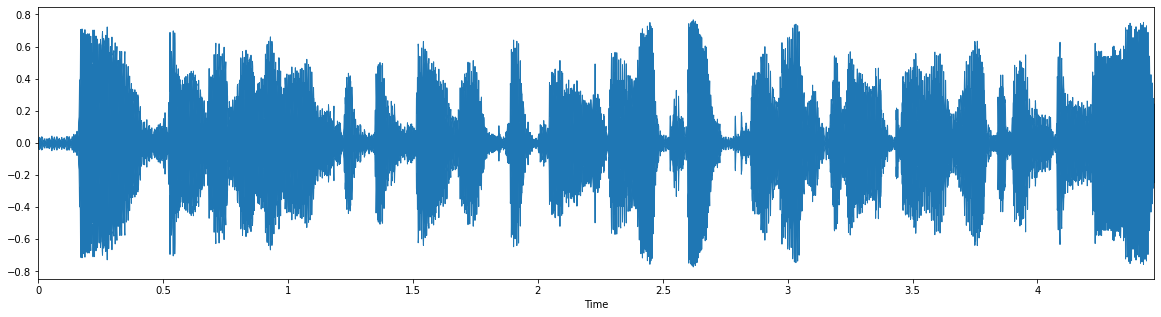

In [ ]:
%matplotlib inline
import librosa.display
#Plot the signal:
plt.figure(figsize=(20, 5))
librosa.display.waveplot(audio, sr=rate)

In [ ]:
import numpy as np


Function to generate parameters for the spectogram

In [ ]:
from numpy.lib.stride_tricks import as_strided
def spectrogram(samples, fft_length=256, sample_rate=2, hop_length=128):
    """
    Compute the spectrogram for a real signal.
    The parameters follow the naming convention of
    matplotlib.mlab.specgram

    Args:
        samples (1D array): input audio signal
        fft_length (int): number of elements in fft window
        sample_rate (scalar): sample rate
        hop_length (int): hop length (relative offset between neighboring
            fft windows).

    Returns:
        x (2D array): spectrogram [frequency x time]
        freq (1D array): frequency of each row in x

    Note:
        This is a truncating computation e.g. if fft_length=10,
        hop_length=5 and the signal has 23 elements, then the
        last 3 elements will be truncated.
    """
    assert not np.iscomplexobj(samples), "Must not pass in complex numbers"

    window = np.hanning(fft_length)[:, None]
    window_norm = np.sum(window**2)

    # The scaling below follows the convention of
    # matplotlib.mlab.specgram which is the same as
    # matlabs specgram.
    scale = window_norm * sample_rate

    trunc = (len(samples) - fft_length) % hop_length
    x = samples[:len(samples) - trunc]

    # "stride trick" reshape to include overlap
    nshape = (fft_length, (len(x) - fft_length) // hop_length + 1)
    nstrides = (x.strides[0], x.strides[0] * hop_length)
    x = as_strided(x, shape=nshape, strides=nstrides)

    # window stride sanity check
    assert np.all(x[:, 1] == samples[hop_length:(hop_length + fft_length)])

    # broadcast window, compute fft over columns and square mod
    x = np.fft.rfft(x * window, axis=0)
    x = np.absolute(x)**2

    # scale, 2.0 for everything except dc and fft_length/2
    x[1:-1, :] *= (2.0 / scale)
    x[(0, -1), :] /= scale

    freqs = float(sample_rate) / fft_length * np.arange(x.shape[0])

    return x, freqs

In [ ]:
x,freqs= spectrogram(audio)
freqs

array([0.       , 0.0078125, 0.015625 , 0.0234375, 0.03125  , 0.0390625,
       0.046875 , 0.0546875, 0.0625   , 0.0703125, 0.078125 , 0.0859375,
       0.09375  , 0.1015625, 0.109375 , 0.1171875, 0.125    , 0.1328125,
       0.140625 , 0.1484375, 0.15625  , 0.1640625, 0.171875 , 0.1796875,
       0.1875   , 0.1953125, 0.203125 , 0.2109375, 0.21875  , 0.2265625,
       0.234375 , 0.2421875, 0.25     , 0.2578125, 0.265625 , 0.2734375,
       0.28125  , 0.2890625, 0.296875 , 0.3046875, 0.3125   , 0.3203125,
       0.328125 , 0.3359375, 0.34375  , 0.3515625, 0.359375 , 0.3671875,
       0.375    , 0.3828125, 0.390625 , 0.3984375, 0.40625  , 0.4140625,
       0.421875 , 0.4296875, 0.4375   , 0.4453125, 0.453125 , 0.4609375,
       0.46875  , 0.4765625, 0.484375 , 0.4921875, 0.5      , 0.5078125,
       0.515625 , 0.5234375, 0.53125  , 0.5390625, 0.546875 , 0.5546875,
       0.5625   , 0.5703125, 0.578125 , 0.5859375, 0.59375  , 0.6015625,
       0.609375 , 0.6171875, 0.625    , 0.6328125, 

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
def plot_spectrogram_feature(vis_spectrogram_feature):
    # plot the normalized spectrogram
    fig = plt.figure(figsize=(12,5))
    ax = fig.add_subplot(111)
    im = ax.imshow(vis_spectrogram_feature, cmap=plt.cm.jet, aspect='auto')
    plt.title('Spectrogram')
    plt.ylabel('Time')
    plt.xlabel('Frequency')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    plt.show()

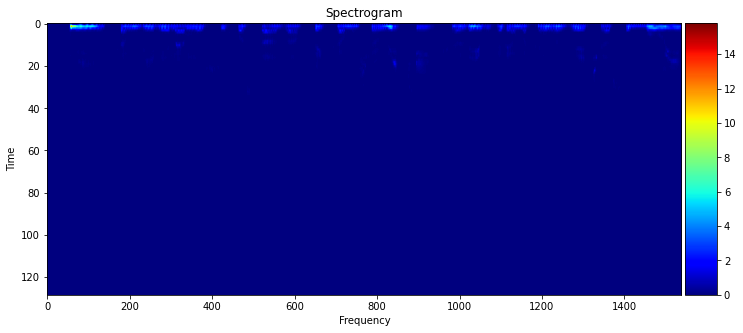

In [ ]:
plot_spectrogram_feature(x)

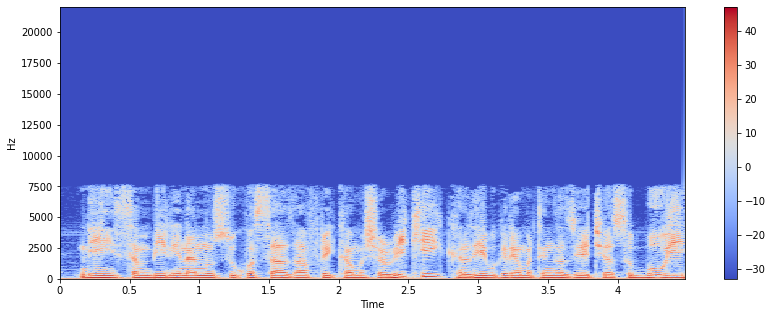

In [ ]:
X = librosa.stft(audio)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=rate, x_axis='time', y_axis='hz')
plt.colorbar()

### Acoustic Modelling

1. Convert abstracts from list of strings into list of lists of integers (sequences)
2. Create feature and labels from sequences
3. Build LSTM model with Embedding, LSTM, and Dense layers
4. Load in pre-trained embeddings
5. Train model to predict next work in sequence
6. Make predictions by passing in starting sequence

In [ ]:
supported = """
ሀ ሁ ሂ ሄ ህ ሆ
ለ ሉ ሊ ላ ሌ ል ሎ ሏ
መ ሙ ሚ ማ ሜ ም ሞ ሟ
ረ ሩ ሪ ራ ሬ ር ሮ ሯ
ሰ ሱ ሲ ሳ ሴ ስ ሶ ሷ
ሸ ሹ ሺ ሻ ሼ ሽ ሾ ሿ
ቀ ቁ ቂ ቃ ቄ ቅ ቆ ቋ
በ ቡ ቢ ባ ቤ ብ ቦ ቧ
ቨ ቩ ቪ ቫ ቬ ቭ ቮ ቯ
ተ ቱ ቲ ታ ቴ ት ቶ ቷ
ቸ ቹ ቺ ቻ ቼ ች ቾ ቿ
ኋ
ነ ኑ ኒ ና ኔ ን ኖ ኗ
ኘ ኙ ኚ ኛ ኜ ኝ ኞ ኟ
አ ኡ ኢ ኤ እ ኦ
ኧ
ከ ኩ ኪ ካ ኬ ክ ኮ
ኳ
ወ ዉ ዊ ዋ ዌ ው ዎ
ዘ ዙ ዚ ዛ ዜ ዝ ዞ ዟ
ዠ ዡ ዢ ዣ ዤ ዥ ዦ ዧ
የ ዩ ዪ ያ ዬ ይ ዮ
ደ ዱ ዲ ዳ ዴ ድ ዶ ዷ
ጀ ጁ ጂ ጃ ጄ ጅ ጆ ጇ
ገ ጉ ጊ ጋ ጌ ግ ጐ ጓ ጔ
ጠ ጡ ጢ ጣ ጤ ጥ ጦ ጧ
ጨ ጩ ጪ ጫ ጬ ጭ ጮ ጯ
ጰ ጱ ጲ ጳ ጴ ጵ ጶ ጷ
ፀ ፁ ፂ ፃ ፄ ፅ ፆ ፇ
ፈ ፉ ፊ ፋ ፌ ፍ ፎ ፏ
ፐ ፑ ፒ ፓ ፔ ፕ ፖ
""".split()

char_map = {}
char_map[""] = 0
char_map["<SPACE>"] = 1
index = 2
for c in supported:
    char_map[c] = index
    index += 1
index_map = {v+1: k for k, v in char_map.items()}

#### Defining the model

In [ ]:
def model_1(input_dim, units, activation, output_dim=29):
    """ Build a recurrent network for speech 
    """
    # Main acoustic input
    input_data = Input(name='the_input', shape=(None, input_dim))
    # Add recurrent layer
    simp_rnn = GRU(units, activation=activation,
        return_sequences=True, implementation=2, name='rnn')(input_data)
    # TODO: Add batch normalization 
    bn_rnn = BatchNormalization()(simp_rnn)
    # TODO: Add a TimeDistributed(Dense(output_dim)) layer
    time_dense = TimeDistributed(Dense(output_dim))(bn_rnn)
    # Add softmax activation layer
    y_pred = Activation('softmax', name='softmax')(time_dense)
    # Specify the model
    model = Model(inputs=input_data, outputs=y_pred)
    model.output_length = lambda x: x
    print(model.summary())
    plot_model(model, to_file='models/model_1.png')
    return model

In [ ]:
def calc_feat_dim(window, max_freq):
    return int(0.001 * window * max_freq) + 1

Convert each sample to a spectogram

In [ ]:
def spectrogram(samples, fft_length=256, sample_rate=2, hop_length=128):
    """
    Compute the spectrogram for a real signal.
    The parameters follow the naming convention of
    matplotlib.mlab.specgram

    Args:
        samples (1D array): input audio signal
        fft_length (int): number of elements in fft window
        sample_rate (scalar): sample rate
        hop_length (int): hop length (relative offset between neighboring
            fft windows).

    Returns:
        x (2D array): spectrogram [frequency x time]
        freq (1D array): frequency of each row in x

    Note:
        This is a truncating computation e.g. if fft_length=10,
        hop_length=5 and the signal has 23 elements, then the
        last 3 elements will be truncated.
    """
    assert not np.iscomplexobj(samples), "Must not pass in complex numbers"

    window = np.hanning(fft_length)[:, None]
    window_norm = np.sum(window**2)

    # The scaling below follows the convention of
    # matplotlib.mlab.specgram which is the same as
    # matlabs specgram.
    scale = window_norm * sample_rate

    trunc = (len(samples) - fft_length) % hop_length
    x = samples[:len(samples) - trunc]

    # "stride trick" reshape to include overlap
    nshape = (fft_length, (len(x) - fft_length) // hop_length + 1)
    nstrides = (x.strides[0], x.strides[0] * hop_length)
    x = as_strided(x, shape=nshape, strides=nstrides)

    # window stride sanity check
    assert np.all(x[:, 1] == samples[hop_length:(hop_length + fft_length)])

    # broadcast window, compute fft over columns and square mod
    x = np.fft.rfft(x * window, axis=0)
    x = np.absolute(x)**2

    # scale, 2.0 for everything except dc and fft_length/2
    x[1:-1, :] *= (2.0 / scale)
    x[(0, -1), :] /= scale

    freqs = float(sample_rate) / fft_length * np.arange(x.shape[0])

    return x, freqs

In [ ]:
"""
Plotting functions
"""

import pickle
import matplotlib.pyplot as plt

def plot_hist(p):
    hist = pickle.load(open( "models/" + p + ".pickle", "rb"))
    plt.plot(hist['loss'], label="train")
    plt.plot(hist['val_loss'], label="valid")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend()
    plt.show